# crime hotspots

This project predicts crime hotspots for the next 24 hours by forecasting the likely locations
(latitude and longitude), types of crimes (e.g., theft, assault), and the expected number of crimes 
per hour. By combining these predictions, the system helps identify where and when crimes might occur,
enabling law enforcement to take proactive measures to prevent crimes and improve community safety.

In [1]:
import folium
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import cycle
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from datetime import datetime, timedelta
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,mean_absolute_error, mean_squared_error, r2_score,ConfusionMatrixDisplay


In [2]:
pd.set_option('display.max_columns',None)
df = pd.read_csv('crimes_1_1_2022_to_31_12_2023.csv')

In [3]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,13324788,JG561261,12/31/2023 08:50:00 PM,009XX E 104TH ST,143A,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,APARTMENT,True,False,512,5,9.0,50,15,1184238.0,1836191.0,2023,01/08/2024 03:59:56 PM,41.705678,-87.600944,"(41.705677782, -87.600944364)"
1,13325064,JG561253,12/31/2023 08:50:00 PM,013XX W WINONA ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,2033,20,47.0,3,08B,1166460.0,1934330.0,2023,01/08/2024 03:59:56 PM,41.975377,-87.663242,"(41.975377229, -87.66324204)"
2,13324754,JG561269,12/31/2023 08:49:00 PM,003XX N GREEN ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,BAR OR TAVERN,False,True,1214,12,27.0,28,08B,1170677.0,1902199.0,2023,01/08/2024 03:59:56 PM,41.887117,-87.648678,"(41.887116764, -87.64867829)"
3,13324767,JG561240,12/31/2023 08:46:00 PM,067XX N SHERIDAN RD,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESTAURANT,False,True,2432,24,49.0,1,08B,1167019.0,1945161.0,2023,01/08/2024 03:59:56 PM,42.005086,-87.660874,"(42.005085732, -87.660873664)"
4,13324756,JG561245,12/31/2023 08:46:00 PM,029XX W FULTON ST,031A,ROBBERY,ARMED - HANDGUN,GAS STATION,False,False,1222,12,27.0,27,03,1156638.0,1901864.0,2023,01/08/2024 03:59:56 PM,41.886493,-87.700243,"(41.886493289, -87.700242574)"


In [4]:
df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

## Standardizing Column Names

In [5]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [6]:
df.columns

Index(['id', 'case_number', 'date', 'block', 'iucr', 'primary_type',
       'description', 'location_description', 'arrest', 'domestic', 'beat',
       'district', 'ward', 'community_area', 'fbi_code', 'x_coordinate',
       'y_coordinate', 'year', 'updated_on', 'latitude', 'longitude',
       'location'],
      dtype='object')

In [7]:
df.describe()

,id,beat,district,ward,community_area,x_coordinate,y_coordinate,year,latitude,longitude
count,5.009810e+05,500981.000000,500981.000000,500969.000000,500981.000000,4.959920e+05,4.959920e+05,500981.000000,495992.000000,495992.000000
mean,1.292752e+07,1155.134089,11.321699,23.258573,36.279436,1.165351e+06,1.887215e+06,2022.523489,41.846097,-87.668703
std,7.030717e+05,710.148565,7.097647,14.107503,21.570666,1.656672e+04,3.200950e+04,0.499448,0.088035,0.060252
min,2.654600e+04,111.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,2022.000000,36.619446,-91.686566
25%,1.277694e+07,533.000000,5.000000,10.000000,22.000000,1.153942e+06,1.859495e+06,2022.000000,41.769887,-87.710207
50%,1.296096e+07,1033.000000,10.000000,24.000000,32.000000,1.167162e+06,1.893492e+06,2023.000000,41.863407,-87.661858
75%,1.314692e+07,1731.000000,17.000000,34.000000,53.000000,1.176818e+06,1.910248e+06,2023.000000,41.909636,-87.626637
max,1.355123e+07,2535.000000,31.000000,50.000000,77.000000,1.205119e+06,1.951506e+06,2023.000000,42.022549,-87.524532


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500981 entries, 0 to 500980
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    500981 non-null  int64  
 1   case_number           500981 non-null  object 
 2   date                  500981 non-null  object 
 3   block                 500981 non-null  object 
 4   iucr                  500981 non-null  object 
 5   primary_type          500981 non-null  object 
 6   description           500981 non-null  object 
 7   location_description  498662 non-null  object 
 8   arrest                500981 non-null  bool   
 9   domestic              500981 non-null  bool   
 10  beat                  500981 non-null  int64  
 11  district              500981 non-null  int64  
 12  ward                  500969 non-null  float64
 13  community_area        500981 non-null  int64  
 14  fbi_code              500981 non-null  object 
 15  

In [9]:
df['date'] = pd.to_datetime(df['date'])

C:\Users\HP\AppData\Local\Temp\ipykernel_1444\3532345252.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


In [10]:
df.shape

(500981, 22)

## Removing Unnecessary Columns

In [11]:
del df['id']
del df['case_number']
del df['updated_on']
del df['fbi_code']

## Missing Values

In [12]:
df.isna().sum() /len(df) * 100

date                    0.000000
block                   0.000000
iucr                    0.000000
primary_type            0.000000
description             0.000000
location_description    0.462892
arrest                  0.000000
domestic                0.000000
beat                    0.000000
district                0.000000
ward                    0.002395
community_area          0.000000
x_coordinate            0.995846
y_coordinate            0.995846
year                    0.000000
latitude                0.995846
longitude               0.995846
location                0.995846
dtype: float64

In [13]:
df = df.dropna()

### Check for invalid Longitude and Latitude values

In [14]:
invalid_longitude = df[(df['longitude'] < -180) | (df['longitude'] > 180)]
invalid_latitude = df[(df['latitude'] < -90) | (df['latitude'] > 90)]

In [15]:
print("There isn't longitude out of range") if invalid_longitude.empty else print("There's some longitude out of range")
print("There isn't latitude out of range") if invalid_latitude.empty else print("There's some latitude out of range")

There isn't longitude out of range
There isn't latitude out of range


## EDA

### What are most common types of crimes ?

In [16]:
crime_types = df['primary_type'].value_counts()
crime_types

primary_type
THEFT                                110887
BATTERY                               84828
CRIMINAL DAMAGE                       56971
MOTOR VEHICLE THEFT                   50580
ASSAULT                               43291
DECEPTIVE PRACTICE                    30185
OTHER OFFENSE                         29953
ROBBERY                               19980
WEAPONS VIOLATION                     17281
BURGLARY                              15026
NARCOTICS                              9263
CRIMINAL TRESPASS                      8908
OFFENSE INVOLVING CHILDREN             3444
CRIMINAL SEXUAL ASSAULT                3087
SEX OFFENSE                            2459
PUBLIC PEACE VIOLATION                 1565
HOMICIDE                               1355
INTERFERENCE WITH PUBLIC OFFICER        977
STALKING                                947
ARSON                                   930
PROSTITUTION                            494
INTIMIDATION                            411
LIQUOR LAW VIOLATIO

Text(0.5, 1.0, 'Most Common Types of Crimes')

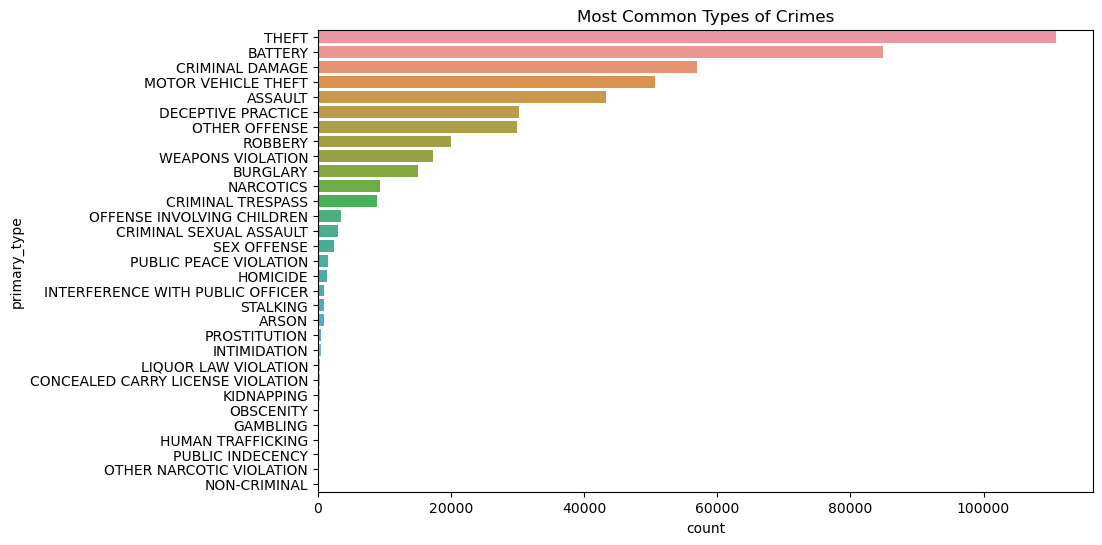

In [17]:
plt.figure(figsize=(10,6))
sns.countplot(data=df,y='primary_type',order=crime_types.index)
plt.title('Most Common Types of Crimes')

* The top crimes (theft, criminal damage, motor vehicle theft) are largely property-related offenses, suggesting that property crime is a significant issue in Chicago.

* While not at the very top, violent crimes like battery, assault, and robbery are still quite common, indicating that violent crime is also a considerable problem in the city.

* Deceptive practice appears relatively high on the list, suggesting that fraud and other financial crimes are noteworthy issues in Chicago.

* Narcotics violations are present but not among the top crimes.

* Homicide, criminal sexual assault, and weapons violations are present on the list but with lower frequencies. However, their presence is still significant given their severe nature.

###  What is the percentage of crimes resulting in arrests?

In [18]:
arrest_rate = df['arrest'].value_counts(normalize=True) * 100
# check
arrest_rate

arrest
False    88.151225
True     11.848775
Name: proportion, dtype: float64

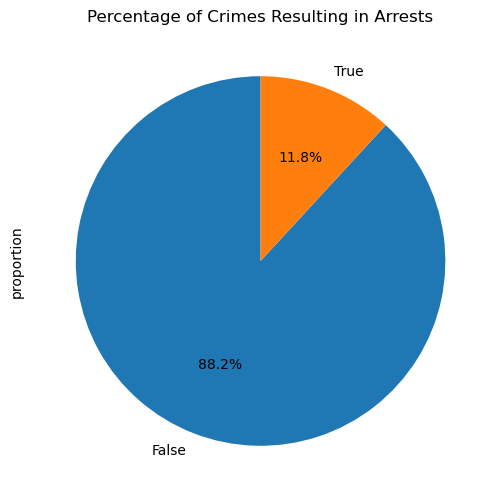

In [19]:
plt.figure(figsize=(10,6))
arrest_rate.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Crimes Resulting in Arrests')
plt.show()

This may indicate that a large percentage of crimes do not lead to arrest, or that there is negligence on the part of the police in arresting criminals.

### What are types of crimes more likely to result in arrests?

In [20]:
arrest_crimes = df[df['arrest'] == True]['primary_type'].value_counts()
# check
arrest_crimes

primary_type
BATTERY                              12820
WEAPONS VIOLATION                    10361
NARCOTICS                             8897
THEFT                                 4826
OTHER OFFENSE                         4553
ASSAULT                               4315
CRIMINAL TRESPASS                     2558
CRIMINAL DAMAGE                       1824
MOTOR VEHICLE THEFT                   1360
ROBBERY                               1139
DECEPTIVE PRACTICE                     963
INTERFERENCE WITH PUBLIC OFFICER       856
BURGLARY                               784
PUBLIC PEACE VIOLATION                 687
HOMICIDE                               487
PROSTITUTION                           478
LIQUOR LAW VIOLATION                   377
CONCEALED CARRY LICENSE VIOLATION      364
OFFENSE INVOLVING CHILDREN             304
SEX OFFENSE                            187
CRIMINAL SEXUAL ASSAULT                136
ARSON                                   97
STALKING                                5

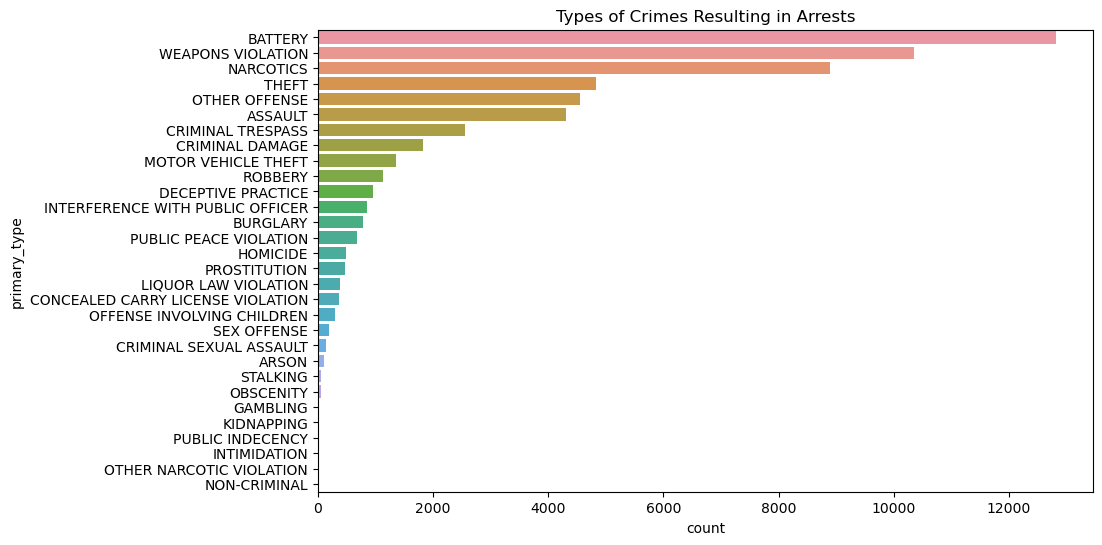

In [21]:
plt.figure(figsize=(10,6))
sns.countplot(y='primary_type', data=df[df['arrest'] == True], order=arrest_crimes.index)
plt.title('Types of Crimes Resulting in Arrests')
plt.show()

There are crimes with lower arrest rates,This may be because, under Chicago law, these crimes do not require arrest and may instead result in a fine or other penalty.

#### What is the number of domestic crimes out of total crimes?

In [22]:
arrest_rate = df['domestic'].value_counts() * 100

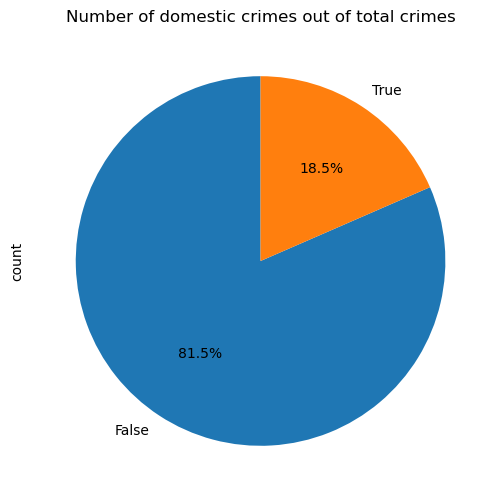

In [23]:
plt.figure(figsize=(10,6))
arrest_rate.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Number of domestic crimes out of total crimes')
plt.show()

### Temporal Analysis

### what is Crime frequency by time of day?

In [24]:
df['hour'] = pd.to_datetime(df['date']).dt.hour

In [25]:
crime_by_hour = df['hour'].value_counts().sort_index()
crime_by_hour

hour
0     38266
1     16350
2     14485
3     12243
4     10004
5      8784
6      9293
7     12494
8     16758
9     20474
10    20609
11    21311
12    27823
13    21785
14    22943
15    26570
16    25855
17    26512
18    26148
19    25471
20    24670
21    22983
22    22085
23    20076
Name: count, dtype: int64

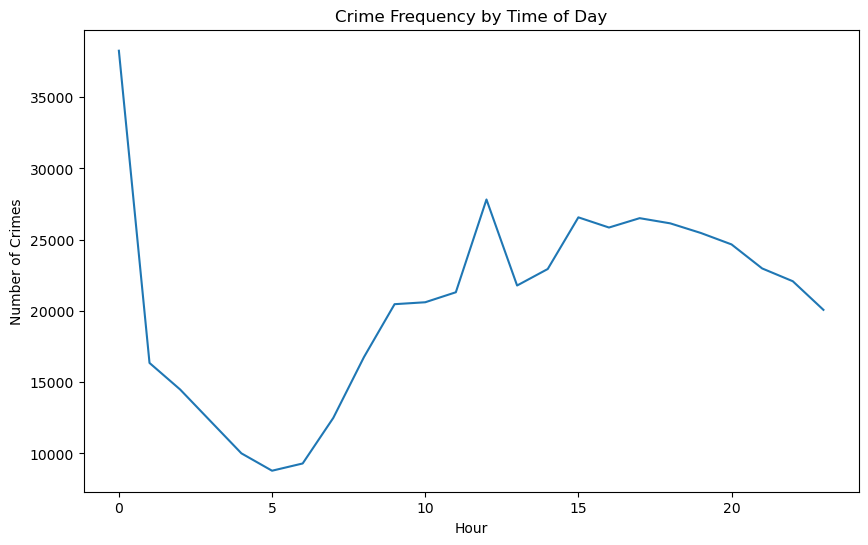

In [26]:
plt.figure(figsize=(10,6))
crime_by_hour.plot(kind='line')
plt.title('Crime Frequency by Time of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Crimes')
plt.show()

* Crime rates are generally higher during nighttime hours (18:00 to 3:00) compared to early morning hours.
* There's a sharp decline in crime rates from midnight to 5 AM.
* The afternoon shows relatively stable crime rates with a slight increase towards evening.

The pattern likely reflects the general rhythm of urban life in Chicago. Higher crime rates during active hours (day and evening) and lower rates during sleeping hours are common in many cities.

### what is crime frequency by day of the week?

In [27]:
df['day_of_week'] = pd.to_datetime(df['date']).dt.day_name()

In [28]:
crime_by_day = df['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
crime_by_day

day_of_week
Monday       69635
Tuesday      69855
Wednesday    69864
Thursday     69335
Friday       72713
Saturday     71808
Sunday       70782
Name: count, dtype: int64

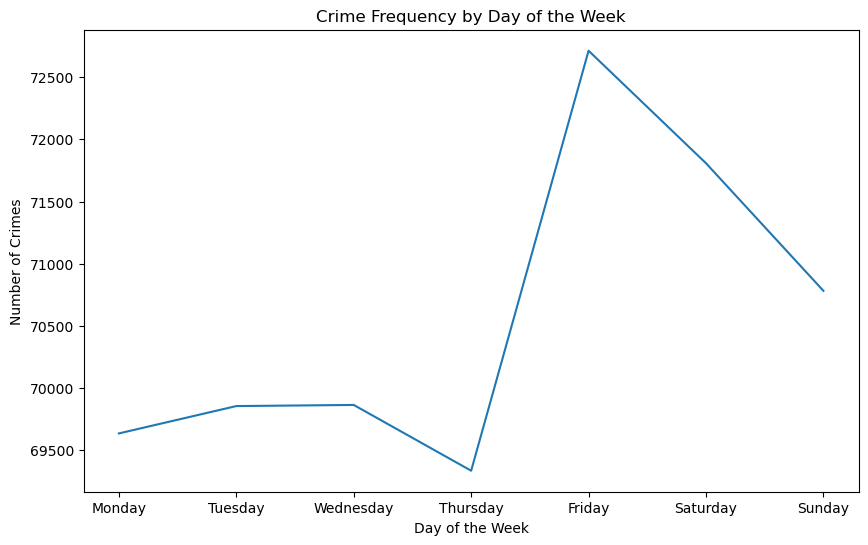

In [29]:
plt.figure(figsize=(10,6))
crime_by_day.plot(kind='line')
plt.title('Crime Frequency by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.show()

There's a clear increase in crime on Fridays and Saturdays, with Friday being the peak. This could be related to more social activities, alcohol consumption, and people being out later at night during weekends

#### What is crime frequency by month?

In [30]:
df['month'] = pd.to_datetime(df['date']).dt.month

In [31]:
crime_by_month = df['month'].value_counts().sort_index()
crime_by_month

month
1     35532
2     33145
3     38457
4     38264
5     41885
6     42960
7     45681
8     45856
9     44269
10    45546
11    41642
12    40755
Name: count, dtype: int64

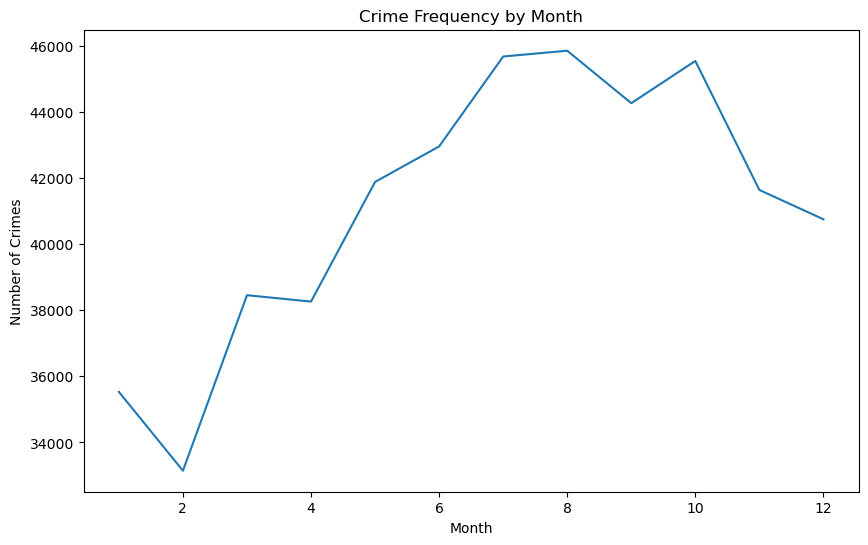

In [32]:
plt.figure(figsize=(10,6))
crime_by_month.plot(kind='line')
plt.title('Crime Frequency by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.show()

There appears to be a clear seasonal trend, with crime rates lowest in winter (February), highest in summer (June-August), and a secondary peak in fall (October)

The seasonal pattern in Chicago's crime rates could be influenced by various factors. Warmer months often see higher crime due to increased outdoor activities and social interactions. Summer tourism and school breaks might also contribute to this rise. Specific events like festivals and holidays can cause fluctuations, while February's drop is likely due to it being the shortest and a very cold month.

The secondary peak in October is interesting and might be linked to specific events or conditions in Chicago during that time, such as Halloween festivities or the start of the school year, which can affect social dynamics and activities.

Overall, weather, school schedules, and events significantly impact crime frequency in Chicago.

### Geographical Analysis

### What are locations with the highest crime rates?

In [33]:
location_crime_counts = df['location_description'].value_counts().head(15)
location_crime_counts

location_description
STREET                                    144678
APARTMENT                                  93669
RESIDENCE                                  61152
SIDEWALK                                   24899
PARKING LOT / GARAGE (NON RESIDENTIAL)     19194
SMALL RETAIL STORE                         14443
ALLEY                                      11062
RESTAURANT                                 10174
DEPARTMENT STORE                            7461
OTHER (SPECIFY)                             7301
COMMERCIAL / BUSINESS OFFICE                7174
VEHICLE NON-COMMERCIAL                      6752
RESIDENCE - PORCH / HALLWAY                 6142
GAS STATION                                 6064
RESIDENCE - GARAGE                          5324
Name: count, dtype: int64

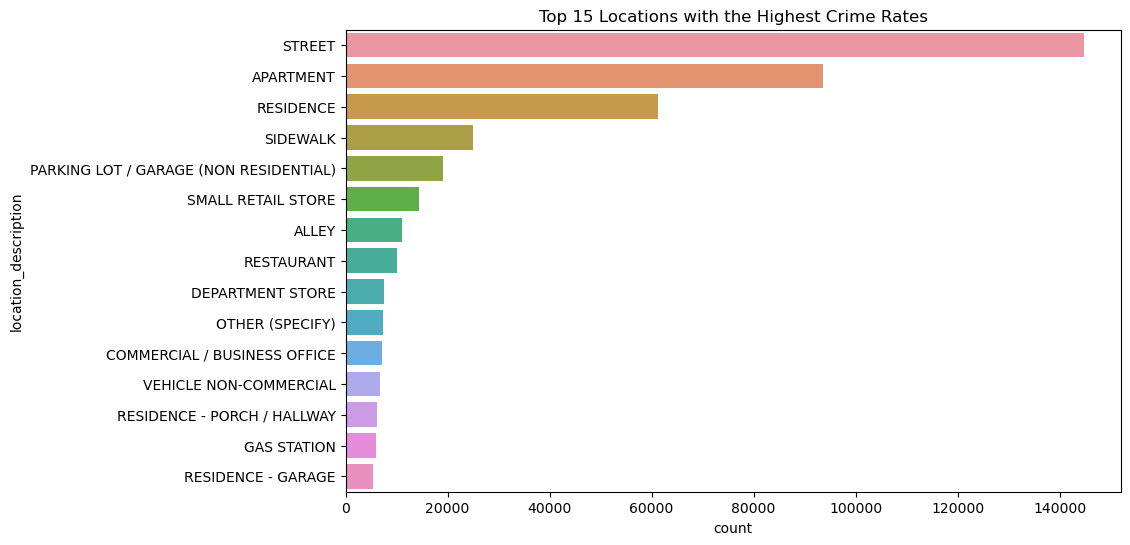

In [34]:
plt.figure(figsize=(10,6))
sns.countplot(y='location_description', data=df, order=location_crime_counts.index)
plt.title('Top 15 Locations with the Highest Crime Rates')
plt.show()

* Public spaces are the most common locations for crimes. Streets, sidewalks, and alleys account for a large portion of criminal incidents. This suggests that many crimes may be opportunistic or occur during people's daily movements through the city.

* Apartments and residences rank second and third, respectively, indicating that a substantial amount of crime occurs in or near people's homes.

* Commercial areas experience notable crime rates. Various types of stores (small retail, department stores) and restaurants feature in the top 15.

### What are District with the highest crime rates?

In [35]:
district_crime_counts = df['district'].value_counts().head(15)
district_crime_counts

district
8     31460
6     30224
12    29747
4     28649
11    27229
1     26793
25    25664
19    25279
18    25110
2     25019
3     24926
9     21801
7     20982
10    20789
5     20103
Name: count, dtype: int64

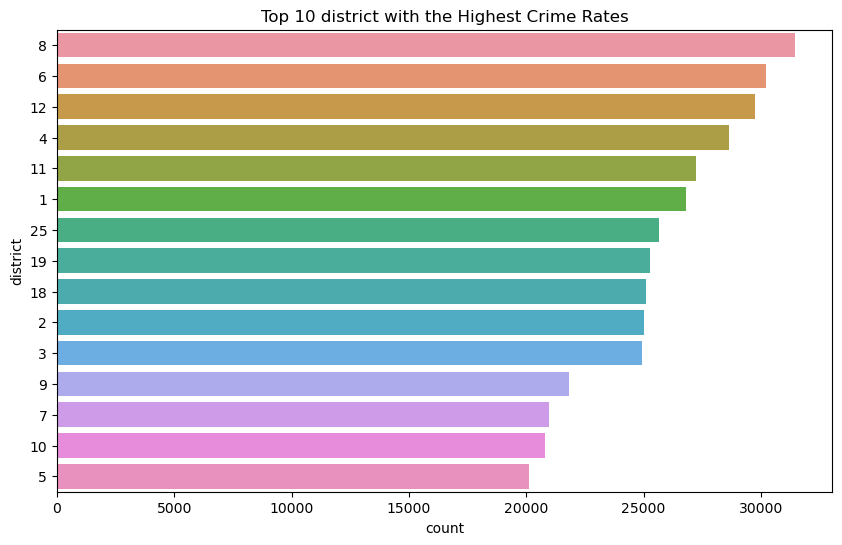

In [36]:
plt.figure(figsize=(10,6))
sns.countplot(y='district', data=df, order=district_crime_counts.index)
plt.title('Top 10 district with the Highest Crime Rates')
plt.show()

These districts are the ones with the highest crime rates in Chicago according to the data presented in the bar graph. This information can be crucial for law enforcement and public policy makers to target interventions and resources effectively.

### What are the hotspots for certain types of crimes?


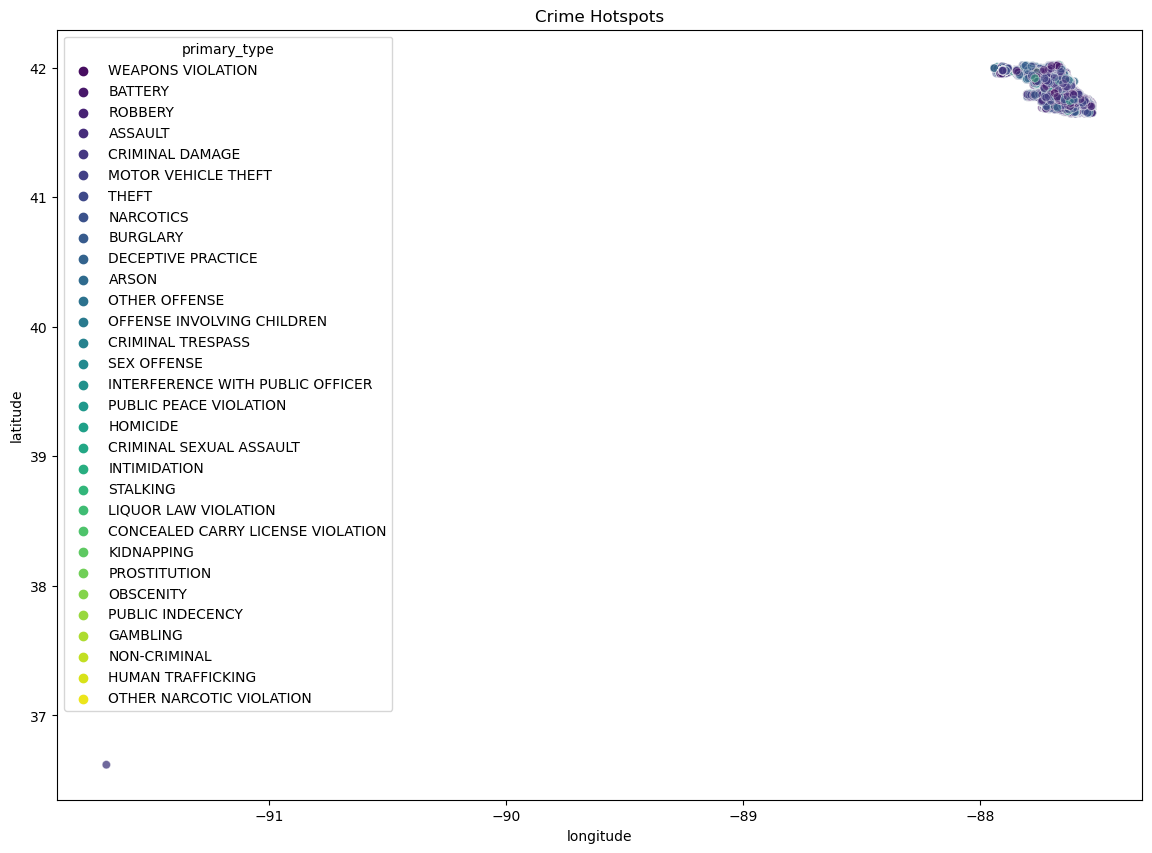

In [37]:
plt.figure(figsize=(14,10))
sns.scatterplot(x='longitude', y='latitude', hue='primary_type', data=df, alpha=0.5, palette='viridis')
plt.title('Crime Hotspots')
plt.show()

Crime is widespread across the city, with higher concentrations in central and northern areas

### What is the correlation between crime rates and community areas

In [38]:
community_crime_counts = df['community_area'].value_counts().head(10)
community_crime_counts

community_area
25    24658
8     21245
28    19535
43    16943
32    16475
24    14918
29    13557
71    13018
23    12943
69    12599
Name: count, dtype: int64

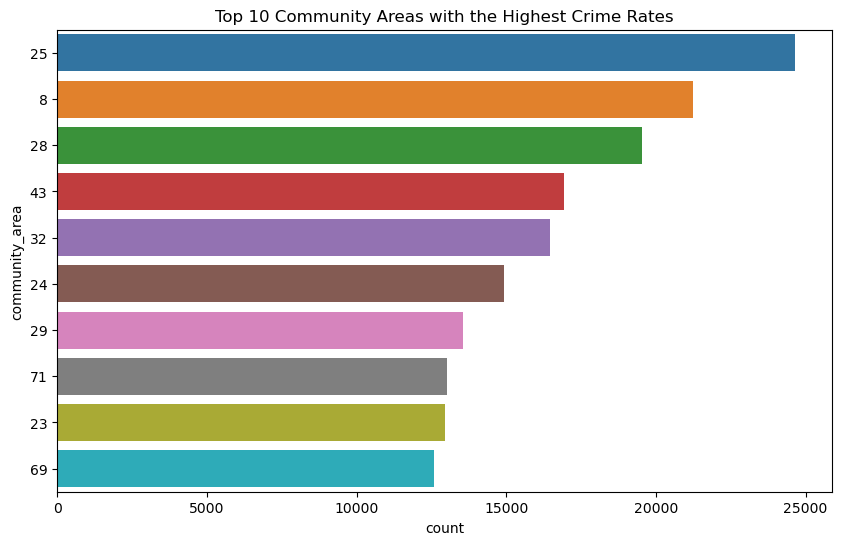

In [39]:
plt.figure(figsize=(10,6))
sns.countplot(y='community_area', data=df, order=community_crime_counts.index)
plt.title('Top 10 Community Areas with the Highest Crime Rates')
plt.show()

the bar chart suggests a variation in crime rates across different community areas in Chicago. The community area '25' stands out with significantly higher crime rates compared to others. This could indicate a need for targeted crime prevention and intervention strategies in this area. The data could be useful for law enforcement and local government to prioritize resources and initiatives to reduce crime in the areas with the highest rates.

## Encodeing 

In [40]:
label_encoder = LabelEncoder()

In [41]:
df['primary_type'] = label_encoder.fit_transform(df['primary_type'])

## Parsing Dates

In [42]:
df.head()

,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,x_coordinate,y_coordinate,year,latitude,longitude,location,hour,day_of_week,month
0,2023-12-31 20:50:00,009XX E 104TH ST,143A,30,UNLAWFUL POSSESSION - HANDGUN,APARTMENT,True,False,512,5,9.0,50,1184238.0,1836191.0,2023,41.705678,-87.600944,"(41.705677782, -87.600944364)",20,Sunday,12
1,2023-12-31 20:50:00,013XX W WINONA ST,0486,2,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,2033,20,47.0,3,1166460.0,1934330.0,2023,41.975377,-87.663242,"(41.975377229, -87.66324204)",20,Sunday,12
2,2023-12-31 20:49:00,003XX N GREEN ST,0486,2,DOMESTIC BATTERY SIMPLE,BAR OR TAVERN,False,True,1214,12,27.0,28,1170677.0,1902199.0,2023,41.887117,-87.648678,"(41.887116764, -87.64867829)",20,Sunday,12
3,2023-12-31 20:46:00,067XX N SHERIDAN RD,0486,2,DOMESTIC BATTERY SIMPLE,RESTAURANT,False,True,2432,24,49.0,1,1167019.0,1945161.0,2023,42.005086,-87.660874,"(42.005085732, -87.660873664)",20,Sunday,12
4,2023-12-31 20:46:00,029XX W FULTON ST,031A,26,ARMED - HANDGUN,GAS STATION,False,False,1222,12,27.0,27,1156638.0,1901864.0,2023,41.886493,-87.700243,"(41.886493289, -87.700242574)",20,Sunday,12


In [43]:
del df['location']
del df['day_of_week']
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek

We have removed the location feature because it consists of the latitude and longitude features. Additionally, we will remove the names of the days of the week to simplify the modeling. 

Since we will not be using the date feature because it is of the datetime type, I will replace it with time elements.

## Modling

### Model for predicting coordinates (longitude and latitude) of a crime scene

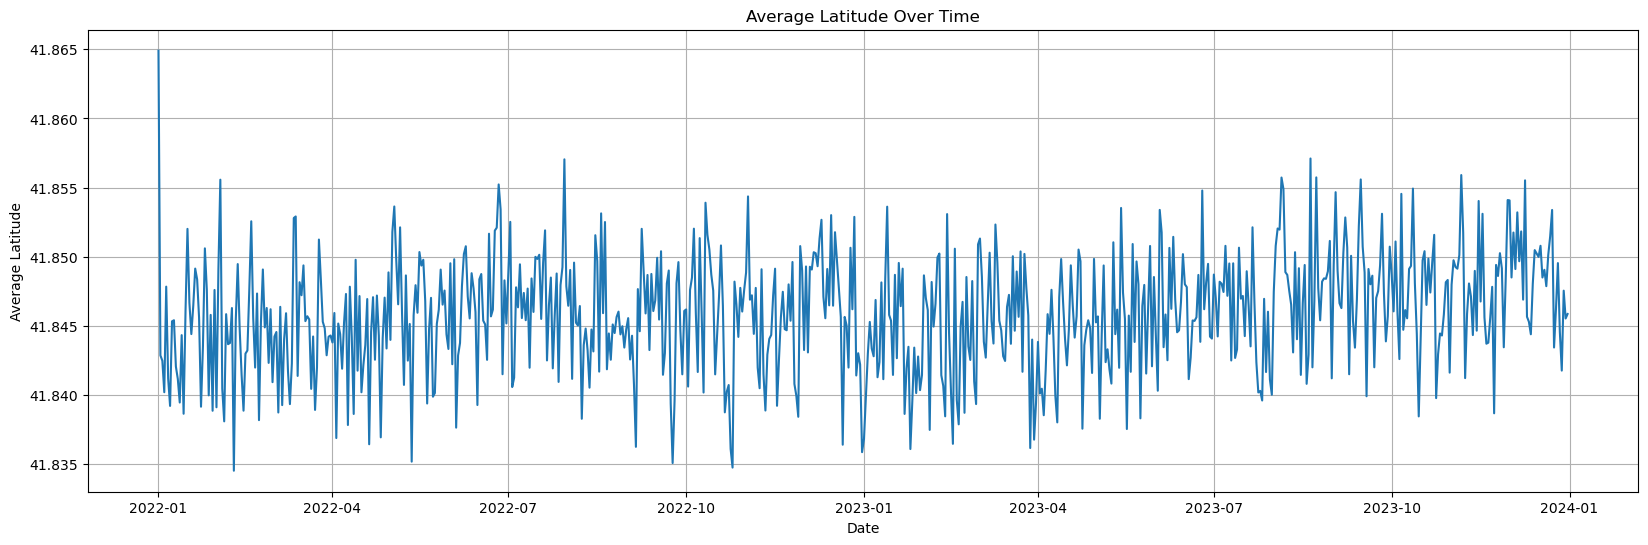

In [44]:
df_daily_avg = df.groupby(df['date'].dt.date)['latitude'].mean()
plt.figure(figsize=(20, 6))
plt.plot(df_daily_avg.index, df_daily_avg.values)
plt.title('Average Latitude Over Time')
plt.xlabel('Date')
plt.ylabel('Average Latitude')
plt.grid(True)
plt.show()

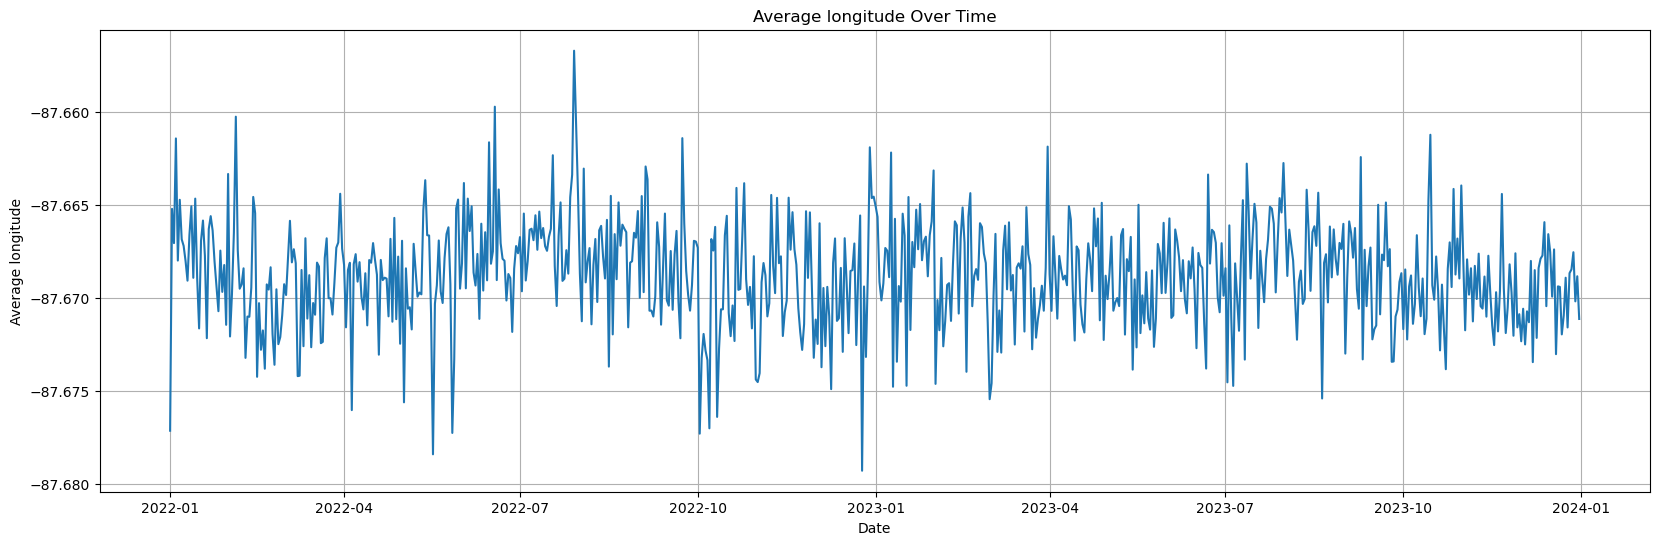

In [45]:
df_daily_avg = df.groupby(df['date'].dt.date)['longitude'].mean()
plt.figure(figsize=(20, 6))
plt.plot(df_daily_avg.index, df_daily_avg.values)
plt.title('Average longitude Over Time')
plt.xlabel('Date')
plt.ylabel('Average longitude')
plt.grid(True)
plt.show()

In [46]:
X = df[['hour', 'day', 'month', 'day_of_week', 'primary_type']]
y = df[['latitude', 'longitude']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
regression_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
regression_model.fit(X, y)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

### Evaluation of the longitude and latitude prediction model

In [48]:
predictions = regression_model.predict(X_test)

In [49]:
mse = mean_squared_error(y_test,predictions)
print(f"Mean Squared Error (MSE): {mse}")
mae = mean_absolute_error(y_test,predictions)
print(f"Mean Absolute Error (MAE): {mae}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")
r2 = r2_score(y_test,predictions)
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 0.0037596126409085717
Mean Absolute Error (MAE): 0.04753571839978646
Root Mean Squared Error (RMSE): 0.06131568022054858
R-squared (R2): 0.32753441756899754


Crime is influenced by various factors, such as demographics, economic conditions, police presence, and social behaviors. These factors are often difficult to model perfectly, so an R-squared of 0.3 could indicate that model captures some of the underlying patterns but not all of them.

### save the model

In [50]:
joblib.dump(regression_model, 'longitude_and_latitude.pkl')

['longitude_and_latitude.pkl']

### Model for predicting crime type

The Primary type is imbalanced so I will use resampling techniques

In [51]:
X = df[['hour', 'day', 'month', 'day_of_week']]
y = df['primary_type']
X_resampled,y_resampled = SMOTE().fit_resample(X,y)

Text(0.5, 1.0, 'Crime Types Distribution after Resampling')

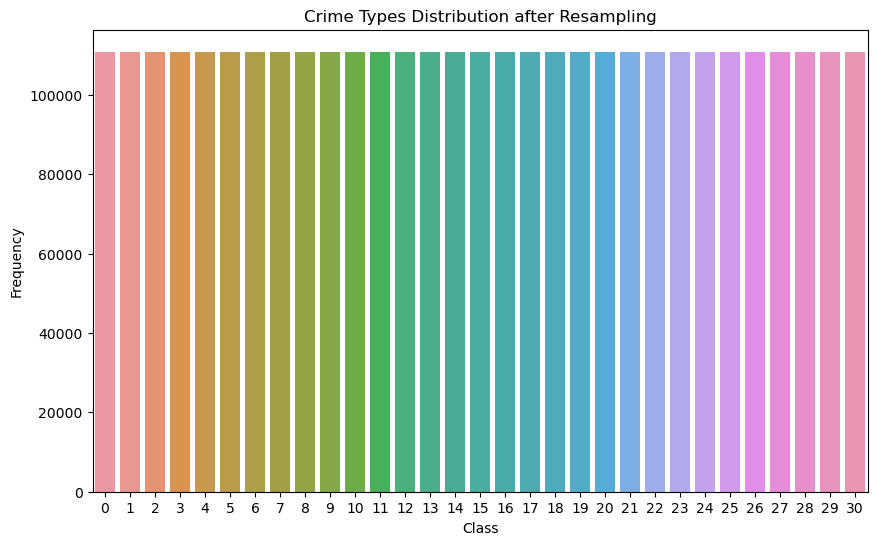

In [52]:
# check
crime_types = y_resampled.value_counts().sort_index().reset_index() 
crime_types.columns = ['Class', 'Frequency']
plt.figure(figsize=(10,6))
sns.barplot(x='Class', y='Frequency', data=crime_types)
plt.title('Crime Types Distribution after Resampling')

#### Comparison of the three models

In [53]:
y_bin = label_binarize(y_resampled, classes=np.arange(len(label_encoder.classes_)))
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X_resampled, y_bin, test_size=0.5, random_state=42)
y_train, y_test = train_test_split(y_resampled, test_size=0.5, random_state=42)

In [54]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lg_model = LogisticRegression(random_state=1,multi_class='ovr',C=0.1,max_iter=200)

In [55]:
xgb_model = XGBClassifier(n_estimators=300,learning_rate=0.01,max_depth=7,)

In [56]:
rf_model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [57]:
lg_model.fit(X_train,y_train)

LogisticRegression(C=0.1, max_iter=200, multi_class='ovr', random_state=1)

In [58]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [59]:
rf_probs = rf_model.predict_proba(X_test)

In [60]:
lg_probs = lg_model.predict_proba(X_test)

In [61]:
xgb_probs = xgb_model.predict_proba(X_test)

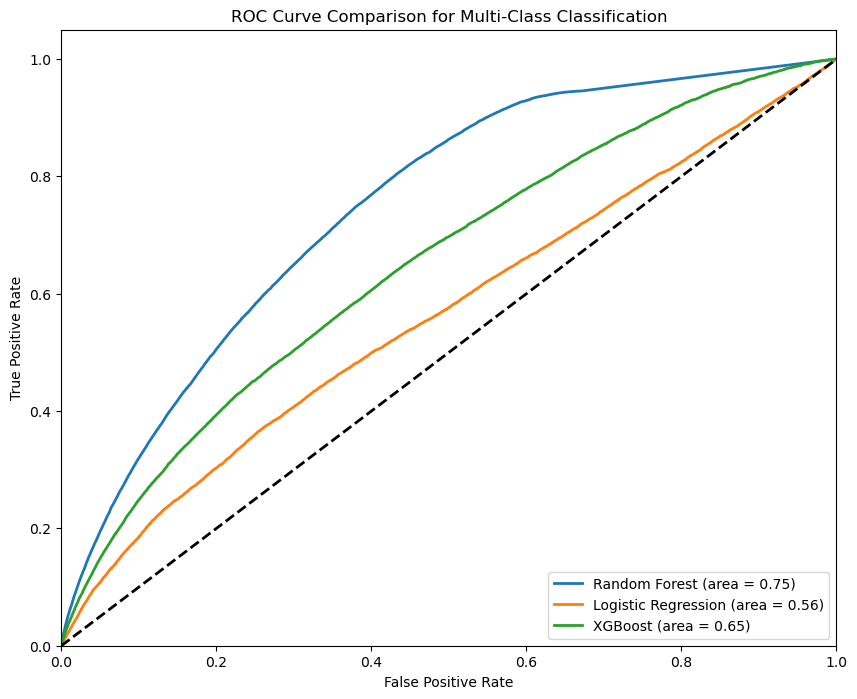

In [62]:
models = {'Random Forest': rf_probs, 'Logistic Regression': lg_probs,'XGBoost':xgb_probs}

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange'])

for model_name, probs in models.items():
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(label_encoder.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # For demonstration, we plot the ROC curve for one specific class
    plt.plot(fpr[2], tpr[2], lw=2, label=f'{model_name} (area = {roc_auc[2]:0.2f})')

# Diagonal line representing random performance
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


In [63]:
rf_pred = rf_model.predict(X_test)
lg_pred = lg_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)


In [64]:
rf_accuracy_score = accuracy_score(y_test, rf_pred)
# Macro-Averaged for random forst
rf_weighted_precision = precision_score(y_test, rf_pred, average='weighted')
rf_weighted_recall = recall_score(y_test, rf_pred, average='weighted')
rf_weighted_f1 = f1_score(y_test, rf_pred, average='weighted')

lg_accuracy_score = accuracy_score(y_test, lg_pred)
# Macro-Averaged for logistic regression
lg_weighted_precision = precision_score(y_test, lg_pred, average='weighted')
lg_weighted_recall = recall_score(y_test, lg_pred, average='weighted')
lg_weighted_f1 = f1_score(y_test, lg_pred, average='weighted')

xgb_accuracy_score = accuracy_score(y_test, xgb_pred)
# Macro-Averaged for SVM
xgb_weighted_precision = precision_score(y_test, xgb_pred , average='weighted')
xgb_weighted_recall = recall_score(y_test, xgb_pred, average='weighted')
xgb_weighted_f1 = f1_score(y_test, xgb_pred, average='weighted')


print(f"Random Forst accuracy: {rf_accuracy_score}")
print(f"Random Forst Weighted-Averaged Precision: {rf_weighted_precision:.2f}")
print(f"Random Forst Weighted-Averaged Recall: {rf_weighted_recall:.2f}")
print(f"Random Forst Weighted-Averaged F1-Score: {rf_weighted_f1:.2f}")
print()
print(f"Logistic Regression accuracy: {lg_accuracy_score}")
print(f"Logistic Regression Weighted-Averaged Precision: {lg_weighted_precision:.2f}")
print(f"Logistic Regression Weighted-Averaged Recall: {lg_weighted_recall:.2f}")
print(f"Logistic Regression Weighted-Averaged F1-Score: {lg_weighted_f1:.2f}")
print()
print(f"XGboost accuracy: {xgb_accuracy_score}")
print(f"XGboost Weighted-Averaged Precision: {xgb_weighted_precision:.2f}")
print(f"XGboost Weighted-Averaged Recall: {xgb_weighted_recall:.2f}")
print(f"XGboost Weighted-Averaged F1-Score: {xgb_weighted_f1:.2f}")


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forst accuracy: 0.5015293099806895
Random Forst Weighted-Averaged Precision: 0.44
Random Forst Weighted-Averaged Recall: 0.50
Random Forst Weighted-Averaged F1-Score: 0.45

Logistic Regression accuracy: 0.07991742831559466
Logistic Regression Weighted-Averaged Precision: 0.04
Logistic Regression Weighted-Averaged Recall: 0.08
Logistic Regression Weighted-Averaged F1-Score: 0.04

XGboost accuracy: 0.274692232548208
XGboost Weighted-Averaged Precision: 0.21
XGboost Weighted-Averaged Recall: 0.27
XGboost Weighted-Averaged F1-Score: 0.21


The results of the decision tree are the best so I will use it and improve it further using randomsearch

In [65]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42,bootstrap=True,oob_score=True),
                        {'n_estimators':[100, 200],
                         'max_depth':[20, 30],
                         'min_samples_leaf':[5, 10]},cv=3, scoring='accuracy',n_iter=4)

In [66]:
random_search.fit(X_train,y_train)
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,260.138533,153.024501,27.030272,2.943399,100,10,20,"{'n_estimators': 100, 'min_samples_leaf': 10, ...",0.486031,0.485279,0.485322,0.485544,0.000345,4
1,598.194878,82.437637,111.864712,34.943890,200,10,30,"{'n_estimators': 200, 'min_samples_leaf': 10, ...",0.486494,0.485912,0.486045,0.486150,0.000249,3
2,323.359036,50.278115,56.768423,2.483544,200,5,30,"{'n_estimators': 200, 'min_samples_leaf': 5, '...",0.491793,0.491152,0.491007,0.491318,0.000341,1
3,125.797709,5.734695,23.087170,2.981580,100,5,20,"{'n_estimators': 100, 'min_samples_leaf': 5, '...",0.491498,0.490924,0.490658,0.491027,0.000350,2


In [67]:
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

Best Parameters: {'n_estimators': 200, 'min_samples_leaf': 5, 'max_depth': 30}
Best Score: 0.4913175171694745


In [68]:
rf_optimized = random_search.best_estimator_

### Evaluation of the primary type prediction model

In [69]:
rf_optimized_pred = rf_optimized.predict(X_test)
rf_accuracy_score = accuracy_score(y_test, rf_optimized_pred)
# Macro-Averaged for random forst
rf_weighted_precision = precision_score(y_test, rf_optimized_pred, average='weighted')
rf_weighted_recall = recall_score(y_test, rf_optimized_pred, average='weighted')
rf_weighted_f1 = f1_score(y_test, rf_optimized_pred, average='weighted')

In [70]:
print(f"Random Forst accuracy: {rf_accuracy_score}")
print(f"Random Forst Weighted-Averaged Precision: {rf_weighted_precision:.2f}")
print(f"Random Forst Weighted-Averaged Recall: {rf_weighted_recall:.2f}")
print(f"Random Forst Weighted-Averaged F1-Score: {rf_weighted_f1:.2f}")

Random Forst accuracy: 0.498142544373844
Random Forst Weighted-Averaged Precision: 0.43
Random Forst Weighted-Averaged Recall: 0.50
Random Forst Weighted-Averaged F1-Score: 0.45


In [71]:
class_report = classification_report(y_test, rf_optimized_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.65      0.55     55584
           1       0.18      0.06      0.09     55458
           2       0.16      0.03      0.05     55421
           3       0.27      0.19      0.22     55289
           4       0.55      0.76      0.64     55516
           5       0.19      0.05      0.08     55393
           6       0.33      0.40      0.36     55377
           7       0.26      0.21      0.23     55471
           8       0.21      0.14      0.17     55464
           9       0.81      0.97      0.88     55163
          10       0.43      0.56      0.49     55794
          11       0.77      0.98      0.86     55362
          12       0.42      0.58      0.49     55575
          13       0.51      0.76      0.61     55299
          14       0.58      0.82      0.68     55398
          15       0.54      0.81      0.65     55254
          16       0.18      0.07      0.10     55146
    

### Save the model

In [72]:
joblib.dump(rf_optimized, 'primary_type.pkl')

['primary_type.pkl']

### Forecast crime counts for the next 24 hours

In [80]:
hourly_crime_counts = df.groupby(['date', 'hour']).size().unstack(fill_value=0)
time_series_model = ExponentialSmoothing(hourly_crime_counts.sum(axis=1), seasonal='add', seasonal_periods=24)
fit_model = time_series_model.fit()
forecast = fit_model.forecast(steps=24)

c:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [81]:
joblib.dump(fit_model, 'time_series.pkl')

['time_series.pkl']

In [82]:
# Generate future dates for prediction
current_time = datetime.now()
future_dates = [current_time + timedelta(hours=x) for x in range(24)]

# Prepare data for Random Forest predictions
forecast_data = pd.DataFrame({
    'hour': [date.hour for date in future_dates],
    'day': [date.day for date in future_dates],
    'month': [date.month for date in future_dates],
    'day_of_week': [date.weekday() for date in future_dates],
    'primary_type': np.nan  # We will predict 'Primary Type' later
})


### Predict for next 24 hours

##### Predict 'Primary Type' for forecasted data 

In [83]:
forecast_data['primary_type'] = rf_optimized.predict(forecast_data[['hour', 'day', 'month', 'day_of_week']])

##### Predict latitude and longitude

In [84]:
forecast_lat_and_long = regression_model.predict(forecast_data[['hour', 'day', 'month', 'day_of_week', 'primary_type']])

In [87]:
# Add predictions to the DataFrame
forecast_data['latitude'] = forecast_lat_and_long[:,0]
forecast_data['longitude'] = forecast_lat_and_long[:,1]

print("Forecasted future coordinates:")
forecast_data

Forecasted future coordinates:


,hour,day,month,day_of_week,primary_type,latitude,longitude
0,3,18,8,6,10,41.861020,-87.697844
1,4,18,8,6,10,41.869921,-87.694219
2,5,18,8,6,10,41.804923,-87.652541
3,6,18,8,6,4,41.905135,-87.872790
4,7,18,8,6,10,41.762089,-87.630327
5,8,18,8,6,25,41.885087,-87.681417
6,9,18,8,6,2,41.809875,-87.661432
7,10,18,8,6,4,41.846793,-87.714196
8,11,18,8,6,4,41.856252,-87.699966
9,12,18,8,6,4,41.843671,-87.691478


In [98]:
simulated_data = []
for i in range(24):
    forecast_count = int(forecast.iloc[i])
    if forecast_count > 0:
        for _ in range(forecast_count):
            simulated_data.append({
                'latitude': forecast_data['latitude'].iloc[i],
                'longitude': forecast_data['longitude'].iloc[i],
                'hour': forecast_data['hour'].iloc[i],
                'day': forecast_data['day'].iloc[i],
                'month': forecast_data['month'].iloc[i],
                'day_of_week': forecast_data['day_of_week'].iloc[i],
                'primary_type': forecast_data['primary_type'].iloc[i]
            })

simulated_df = pd.DataFrame(simulated_data)
print("Simulated data preview:")
simulated_df

Simulated data preview:


,latitude,longitude,hour,day,month,day_of_week,primary_type
0,41.861020,-87.697844,3,18,8,6,10
1,41.869921,-87.694219,4,18,8,6,10
2,41.869921,-87.694219,4,18,8,6,10
3,41.804923,-87.652541,5,18,8,6,10
4,41.804923,-87.652541,5,18,8,6,10
5,41.905135,-87.872790,6,18,8,6,4
6,41.762089,-87.630327,7,18,8,6,10
7,41.762089,-87.630327,7,18,8,6,10
8,41.885087,-87.681417,8,18,8,6,25
9,41.809875,-87.661432,9,18,8,6,2


In [100]:
color_map = {
    'THEFT': 'red',
    'BATTERY': 'blue',
    'CRIMINAL DAMAGE': 'green',
    'MOTOR VEHICLE THEFT': 'purple',
    'ASSAULT': 'orange',
    'DECEPTIVE PRACTICE': 'darkred',
    'OTHER OFFENSE': 'lightred',
    'ROBBERY': 'darkblue',
    'WEAPONS VIOLATION': 'darkgreen',
    'BURGLARY': 'cadetblue',
    'NARCOTICS': 'cyan',
    'CRIMINAL TRESPASS': 'magenta',
    'OFFENSE INVOLVING CHILDREN': 'lime',
    'CRIMINAL SEXUAL ASSAULT': 'coral',
    'SEX OFFENSE': 'teal',
    'PUBLIC PEACE VIOLATION': 'salmon',
    'HOMICIDE': 'gold',
    'INTERFERENCE WITH PUBLIC OFFICER': 'indigo',
    'STALKING': 'violet',
    'ARSON': 'azure',
    'PROSTITUTION': 'peachpuff',
    'INTIMIDATION': 'khaki',
    'LIQUOR LAW VIOLATION': 'sandybrown',
    'CONCEALED CARRY LICENSE VIOLATION': 'tomato',
    'KIDNAPPING': 'orangered',
    'OBSCENITY': 'darkred',
    'GAMBLING': 'olive',
    'HUMAN TRAFFICKING': 'maroon',
    'PUBLIC INDECENCY': 'darkviolet',
    'OTHER NARCOTIC VIOLATION': 'darkslateblue',
    'NON-CRIMINAL': 'lightgrey'
}

#### Inverse label encoding for primary type 

Inverse label encoding for the primary type allows us to easily display colors based on the crime type on the map

In [101]:
label_mapping = dict(enumerate(label_encoder.classes_))
forecast_data['primary_type'] = [label_mapping[label] for label in forecast_data['primary_type']]
simulated_df['primary_type']= [label_mapping[label] for label in simulated_df['primary_type']]

### Hot crime forecast map for the next 24 hours

In [102]:
# Create a Map centered around Chicago
map_center = [41.8781, -87.6298]  # Latitude and Longitude for Chicago
hotspot_map = folium.Map(location=map_center, zoom_start=12)

for crime_type in forecast_data['primary_type'].unique():
    crime_data = simulated_df[simulated_df['primary_type'] == crime_type]
    for _, row in crime_data.iterrows():
        tooltip_text = f"Crime: {row['primary_type']}, Hour: {row['hour']}"
        folium.CircleMarker(
            location=(row['latitude'], row['longitude']),
            radius=7,
            color=color_map[crime_type],
            fill=True,
            fill_color=color_map[crime_type],
            fill_opacity=0.7,
            tooltip=tooltip_text  
        ).add_to(hotspot_map)

# Save the map to an HTML file
hotspot_map.save('hotspot_map.html')
print("Hotspot prediction and visualization complete. The map is saved as hotspot_map.html")


Hotspot prediction and visualization complete. The map is saved as hotspot_map.html


## Results and Insights
* Crime Type Distribution: Theft and property-related crimes were the most common, while violent crimes like battery and assault were also prevalent.
* Arrest Analysis: A significant percentage of crimes did not result in arrests, highlighting potential areas for law enforcement improvement.
* Temporal Trends: Crimes peaked during nighttime hours and on weekends, particularly Fridays and Saturdays.
* Geographical Insights: Certain districts and public spaces were identified as crime hotspots, providing actionable insights for targeted interventions.